# Classification Model for Churn Analysis
- Author: Ronny Kabiru
- Program: DS-FT08 Westlands Hybrid
- Date: 07/06/2024
- TM: Maryann Mwikali


-----
-----

## Business Problem

For telecommunication companies to grow their revenue generating base, it is key to attract new customers and at the same time increase customer retention rate. Customer churn is one of the most important concerns for large companies. Customer churn is a metric showing when a subscriber or a regular customer cancels his subscription or stops doing business with a company. Churn could be due to various factors, including switching to a competitor for better price offers, cancelling their subscription because of poor customer service, or discontinuing all contact with a brand due to insufficient touchpoints.
Syriatel is a provider of mobile telecommunication and data services based in Damascus, Syria. The company offers services including calls, news, message, GSM and internet services. It has successfully established its reputation by focusing on customer satisfaction and social responsibility. Syriatel has established that long-term relationships with customers are more effective than trying to attract new customers. To them, working to keep a client is cheaper than working to get a new client. Churn prediction has therefore become a very important part of the company's strategy. This project aims to develop a model which accurately predicts customers who are most likely to churn, and identify the features that are important for predicting customer churn. Syriatel can thus act to prevent the customer who is likely to churn from actually churning.

-----

## The Data

The dataset that I was given to work with contains information for 3333 accounts(columns), including:
- State
- Account Length
- Area Code
- Phone Number
- Extra Plans (VoiceMail and/or International)
- Minutes Used (Day, Evening, Night, International)
- Number of Calls (Day, Evening, Night, International)
- Number of VoiceMail Messages
- Total Amount Charged for minutes used (Day, Evening, Night, International)
- Number of calls to Customer Service

and most importantly:
- Churn: Customers who cancelled their service.

-----

## Questions to Answer
1. What is the Baseline Churn Rate?
2. What factors contribute to churn?
3. What factors have the biggest impact on churn?
4. What can be done to identify when a customer is at risk for churn?
5. What can be done to prevent churn?

-----

## What I will be looking for in my models
1. <b>High Recall Score:</b> I want my model to be able to predict which customers are at risk of churning. If it is tuned to be too sensitive in this area, that is fine. I would rather flag customers that aren't going to churn rather than focus on the customers that are likely to stay, and ending up with unexpected churn. I will keep this in balance by checking F1 Score.

2. <b>Good F1 Score:</b>While I am ultimately not concerned with Precision (how well the model predicts customers that will stay), a good F1 score means that the model is performing well on both Recall and Precision. Since Recall and Precision are inverses of each other, a good F1 score ensures that the model isn't skewed too far toward one or the other. (ie, a model that predicts EVERY customer will churn would have perfect Recall, but would be useless).

3. <b>High Cross Validation Score:</b> This ensures that the model isn't overly trained on the test data and that it does a good job of predicted unseen and unknown data. (ie, the test set).

4. <b>Area Under the Curve (AUC):</b> The ROC AUC Score measures the Area under the ROC curve, which means that it classifies the true positive rate against the false positive rate. The higher the score, the better performing the model is. That said, here is the scale that I will use to evaluate my models:
- <u><b>.69 or less:</u></b> Model performs only slightly better than guessing and is worthless for my analysis.
- <u><b>.70 - .79:</u></b> Model still isn't performing very well, but is at minimum acceptable levels.
- <u><b>.80 - .89:</u></b> Model is performing fairly well. My goal is to be in this range or better.
- <u><b>.90 - .99:</u></b> Model is performing very well. I would be very happy to have a final model in this range.

-----
-----

# Data Preparation

## Importing necessary libraries

In [326]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [327]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed
plt.style.use('fivethirtyeight')

-----

## Reading the file

In [328]:
df = pd.read_csv(r'D:\Moringa Data Science\Moringa Projects\phase-3-individual-project\data\bigml_59c28831336c6604c800002a.csv')

df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


-----

## Checking column names

In [329]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

-----
-----

# EDA

In [330]:
df.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [332]:
df.isna()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3329,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3330,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3331,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [333]:
df.isna().sum()

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

In [334]:
df.phone_number.duplicated().sum()

0

In [335]:
df.churn.value_counts()

churn
False    2850
True      483
Name: count, dtype: int64

There is a Churn Class Imbalance. False has 2850 values and True has 483 values.

In [336]:
# Calculating Churn rate
churn_rate = (483/3333) * 100
print(f'The Churn Rate is', churn_rate,'%')

The Churn Rate is 14.491449144914492 %


In [337]:
# There are 3333 records.
# No missing values, and no duplicates.
# The number of customers who churned was 483.
# Therefore the base churn rate is (483 / 3333) * 100 = 14.49%

## Data Cleaning and Preprocessing

In [338]:
test_df = df.copy()
test_df.head(2)        #Checking the copy is accurate

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


In [339]:
test_df["churn"] = test_df["churn"].astype(int)
test_df.churn.value_counts()

churn
0    2850
1     483
Name: count, dtype: int64

In the above cell, we assign 0 to represent False and 1 to represent True.

In [340]:
# Dropping unnecessary columns
test_df = test_df.drop(columns=['state','phone_number', 'area_code'], axis=1)
test_df.head()

#Those columns are serving as identifiers and won't be necessary for this project

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [341]:
# Adding necessary columns
total_charge = test_df.apply(lambda x: x['total_day_charge'] + x['total_eve_charge'] +x['total_night_charge']
                             +x['total_intl_charge'], axis=1)
test_df['total_charge']= total_charge

#Total Charge represents the summation of charges the customer is billed

-----

### Removing object dtypes

In [342]:
# Select continuous features
cont_features = [col for col in test_df.columns if test_df[col].dtype in [np.float64, np.int64]]

# Ensure 'churn' column is included
if 'churn' not in cont_features:
    cont_features.append('churn')

feature_df = test_df.loc[:, cont_features]
feature_df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_charge,churn
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,75.56,0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,59.24,0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,62.29,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,66.80,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,52.09,0


-----

### One Hot Encoding

In [343]:
need_encode = test_df[['international_plan', 'voice_mail_plan', 'customer_service_calls']]
ohe = OneHotEncoder()
ohe.fit(need_encode)

ohe_1 = ohe.transform(need_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names_out(need_encode.columns))
ohe_df.head(2)

,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [344]:
# Combining everything together
cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
cleaned_df.head(2)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [345]:
#Dropping a few of the redundant values.
cleaned_df_2 = cleaned_df.copy()
cleaned_df_2 = cleaned_df_2.drop(['international_plan_no', 'voice_mail_plan_no'], axis=1)
cleaned_df_2.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


-----

## Creating Variable: Customer Service Calls High
- Customer Service Calls High = 4 or more Customer Service Calls.
- This is to determine if a high number of Customer Service Calls affects Churn.
- I'm introducing only the High Customer Service Calls variable as any account that isn't in the "High" range is in the "Low" range.

In [346]:
cs_calls_high= cleaned_df_2.apply(lambda x: x['customer_service_calls_4'] + x['customer_service_calls_5']
                                           + x['customer_service_calls_6'] + x['customer_service_calls_7']
                                            + x['customer_service_calls_8']+ x['customer_service_calls_9'], axis=1)

cleaned_df_2['cs_calls_high'] = cs_calls_high

In [347]:
cleaned_df_2 = cleaned_df_2.drop(['customer_service_calls_0', 'customer_service_calls_1','customer_service_calls_2','customer_service_calls_3',
                                    'customer_service_calls_4','customer_service_calls_5','customer_service_calls_6',
                                        'customer_service_calls_7','customer_service_calls_8','customer_service_calls_9']
                                            , axis=1)
cleaned_df_2.head(2)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_charge,churn,international_plan_yes,voice_mail_plan_yes,cs_calls_high
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,75.56,0,0.0,1.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,59.24,0,0.0,1.0,0.0


In [348]:
total_charge = cleaned_df_2.apply(lambda x: x['total_day_charge'] + x['total_eve_charge'] +x['total_night_charge']
                             +x['total_intl_charge'], axis=1)
cleaned_df_2['total_charge']= total_charge

-----
-----

# Modeling

In [349]:
# Creating a df that we'll use for modeling
model_df = cleaned_df_2.copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   number_vmail_messages   3333 non-null   int64  
 2   total_day_minutes       3333 non-null   float64
 3   total_day_calls         3333 non-null   int64  
 4   total_day_charge        3333 non-null   float64
 5   total_eve_minutes       3333 non-null   float64
 6   total_eve_calls         3333 non-null   int64  
 7   total_eve_charge        3333 non-null   float64
 8   total_night_minutes     3333 non-null   float64
 9   total_night_calls       3333 non-null   int64  
 10  total_night_charge      3333 non-null   float64
 11  total_intl_minutes      3333 non-null   float64
 12  total_intl_calls        3333 non-null   int64  
 13  total_intl_charge       3333 non-null   float64
 14  customer_service_calls  3333 non-null   

In [350]:
# Removing noise in the dataframe
model_df=model_df.drop(['customer_service_calls','total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge'], axis=1)
model_df.head(2)


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_charge,churn,international_plan_yes,voice_mail_plan_yes,cs_calls_high
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,75.56,0,0.0,1.0,0.0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,59.24,0,0.0,1.0,0.0


-----

### Correcting imbalance in the Churn class

In [351]:
balanced_df = model_df.copy()

X = balanced_df.drop(['churn'], axis=1)
y = balanced_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=23)

smote = SMOTE(random_state=23)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

-----

### Function to get necessary metrics
- It will calculate and display the following metrics:
    1. Recall
    2. F1 Score
    3. ROC AUC Score

In [352]:
def metrics(clf, y_pred):
    
    clf_recall = recall_score(y_test, y_pred) * 100
    print('Recall is :{0}'.format(clf_recall))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))
    

-----

## Base Model

### Decision Tree

In [353]:
dt1 = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)

In [354]:
metrics(dt1, dt1_y_pred)

Recall is :84.29752066115702
F1 Score is :79.37743190661479
ROC AUC is :0.9


In [355]:
dt1_cv_score = np.mean(cross_val_score(dt1, X_train_resampled, y_train_resampled, cv=3))
dt1_cv_score

0.9515682699257507

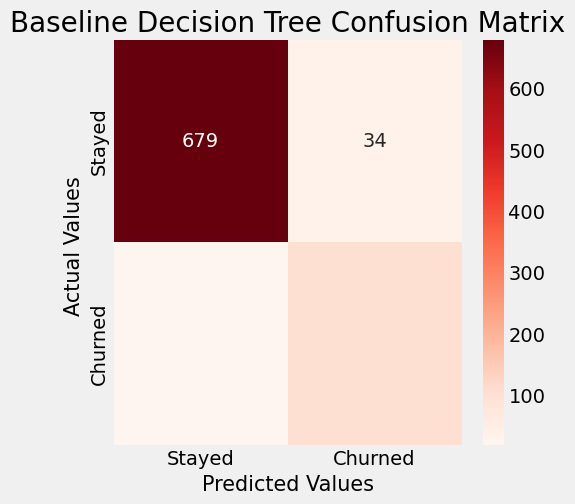

In [356]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Reds', fmt='d', ax=ax, cbar=True)

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 20)
ax.set_xlabel('Predicted Values',fontsize = 15)
ax.set_ylabel('Actual Values ', fontsize=15)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Analysis:
- Recall is decent, F1 score is okay, and ROC AUC score is very good. The first model is performing well.
- I will use GridSearch to optimize my Decision Tree.

### Refining Decision Tree through GridSearchCV

In [357]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [358]:
# Instantiate GridSearchCV
dt2 = DecisionTreeClassifier(random_state=23)

dt_grid_search = GridSearchCV(dt2, dt_param_grid, cv=3, scoring = 'recall')

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [359]:
dt_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

### Decision Tree 2 (Using Grid Search Parameters)

In [360]:
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)

In [361]:
metrics(dt2, dt2_y_pred)

Recall is :85.12396694214877
F1 Score is :82.07171314741036
ROC AUC is :0.91


In [362]:
dt2_cv_score = np.mean(cross_val_score(dt2, X_train_resampled, y_train_resampled, cv=3))
dt2_cv_score

0.9588203889874499

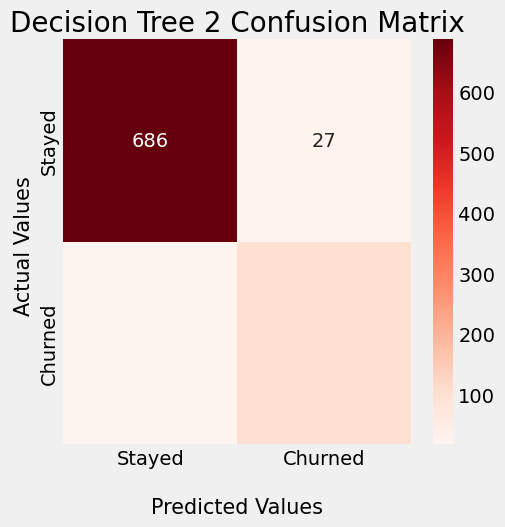

In [363]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt2_matrix, annot=True, cmap='Reds', fmt='d', ax=ax, cbar=True)

ax.set_title('Decision Tree 2 Confusion Matrix', fontsize = 20)
ax.set_xlabel('\nPredicted Values',fontsize = 15)
ax.set_ylabel('Actual Values ', fontsize=15)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Analysis:
- Decision Tree 2 performs slightly better than Decision Tree 1 on all metrics.

 -----

## Model 2: Random Forest

This is a more complex model. I am trying to get a better performance than the previous model.

In [364]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)

In [365]:
metrics(rf1_clf, rf1_y_pred)

Recall is :82.64462809917356
F1 Score is :88.10572687224669
ROC AUC is :0.91


In [366]:
rf1_cv_score = np.mean(cross_val_score(rf1_clf, X_train_resampled, y_train_resampled, cv=3))
rf1_cv_score

0.9728615546356528

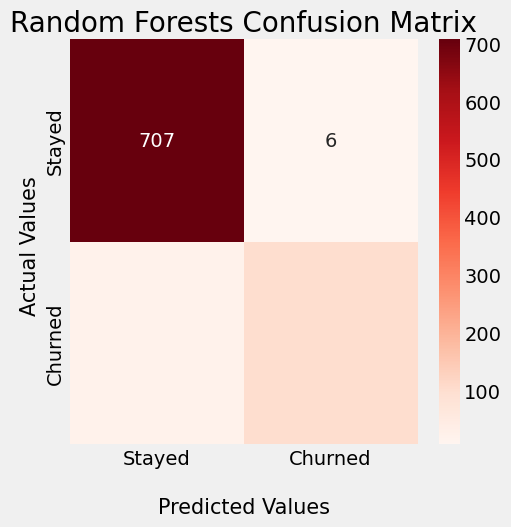

In [367]:
rf1_matrix = confusion_matrix(y_test, rf1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf1_matrix, annot=True, cmap='Reds', fmt='d', ax=ax, cbar=True)

ax.set_title('Random Forests Confusion Matrix', fontsize = 20)
ax.set_xlabel('\nPredicted Values',fontsize = 15)
ax.set_ylabel('Actual Values ', fontsize=15)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Analysis
- My Random Forests model performs better than my Decision Trees in ROC AUC Score and F1 Score.
- The Recall Score is a slightly lower than my Decision Trees. I will run GridSearchCV to optimize my model.

### GridSearchCV

In [368]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [369]:
rf2_clf = RandomForestClassifier(random_state=23)


rf1_grid_search= GridSearchCV(rf2_clf, rf_param_grid, scoring = 'recall', cv=3)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")


Random Forest  Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}


## Random Forests 2 (Using Parameters from GridSearchCV)

In [370]:
rf2_clf = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 3,
                                min_samples_split= 5, n_estimators= 30, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)

In [371]:
metrics(rf2_clf, rf2_y_pred)

Recall is :81.81818181818183
F1 Score is :85.71428571428572
ROC AUC is :0.9


In [372]:
rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train_resampled, y_train_resampled, cv=3))
rf2_cv_score

0.963736612129575

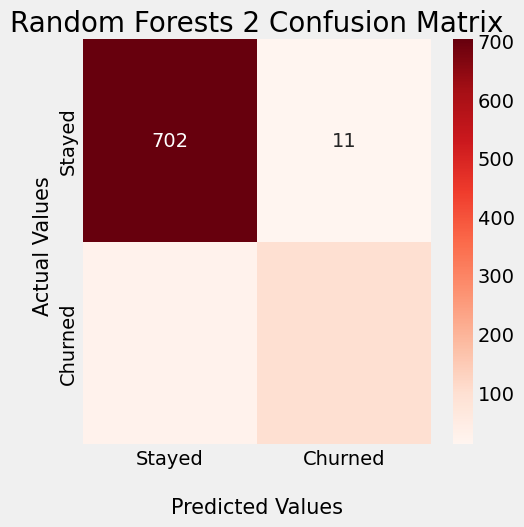

In [373]:
rf2_matrix = confusion_matrix(y_test, rf2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf2_matrix, annot=True, cmap='Reds', fmt='d', ax=ax, cbar=True)

ax.set_title('Random Forests 2 Confusion Matrix', fontsize = 20)
ax.set_xlabel('\nPredicted Values',fontsize = 15)
ax.set_ylabel('Actual Values ', fontsize=15)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Stayed','Churned'])
ax.yaxis.set_ticklabels(['Stayed','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Analysis:
- Even though I used GridSearch and set it to prioritize Recall, this model doesn't do as well as the previous ones.


-----

## Model 3: XGBoost

This is a high performing model. I expect the best results from this model.

In [374]:
# Instantiate XGBClassifier
clf = XGBClassifier(random_state=23)

# Fit XGBClassifier
xg1 = clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
xg1_y_pred = clf.predict(X_test)

In [375]:
metrics(xg1, xg1_y_pred)

Recall is :85.9504132231405
F1 Score is :92.03539823008849
ROC AUC is :0.93


In [376]:
xg1_cv_score = np.mean(cross_val_score(xg1, X_train_resampled, y_train_resampled, cv=3))
xg1_cv_score

0.9763695052237334

### Analysis:
- The XGBoost Model performs closer to the Decision Tree Models. It has the highest F1 Score so far, but Recall is still my biggest criteria and it is slightly below Decision Tree 2.
- I will run GridSearch CV and see if that improves model performance.  

### GridSearchCV

In [377]:
boost_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [378]:
xg2 = XGBClassifier(random_state=23)

grid_clf = GridSearchCV(xg2, boost_param_grid, scoring='recall', cv=3, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))


Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.5


## XGBoost2 (Using Parameters from GridSearchCV)

In [379]:
xg2 = XGBClassifier(learning_rate= 0.2, max_depth=6, min_child_weight=1,
                                n_estimators=100, subsample=0.5, random_state=23)
xg2.fit(X_train_resampled, y_train_resampled)
xg2_y_pred = xg2.predict(X_test)

In [380]:
metrics(xg2, xg2_y_pred)

Recall is :84.29752066115702
F1 Score is :89.47368421052632
ROC AUC is :0.92


In [381]:
xg2_cv_score = np.mean(cross_val_score(xg2, X_train_resampled, y_train_resampled, cv=3))
xg2_cv_score

0.9747319140548

### Analysis

<b>XGBoost Model 1 is my best performing model</b>.
- It has the best Recall Score at 85.95.
- It has the highest F1 Score at 92.03.
- It has the highest Area Under ROC Curve at 0.93.



-----

# Choosing a Final Model

- <b> XGBoost Model 1 is my final model, and will be used for final analysis and recommendations.</b>






-----
-----

# Feature Relevance
- Which features had the most importance in relation to Churn in my Final Model?

In [382]:
feature_names = list(X)
feature_names

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_eve_minutes',
 'total_eve_calls',
 'total_night_minutes',
 'total_night_calls',
 'total_intl_minutes',
 'total_intl_calls',
 'total_charge',
 'international_plan_yes',
 'voice_mail_plan_yes',
 'cs_calls_high']

In [383]:
xg2_importance = xg2.feature_importances_
xg2_importance

array([0.018979  , 0.01654863, 0.01673285, 0.01901814, 0.01720953,
       0.01740543, 0.02066004, 0.01468934, 0.02805669, 0.05064264,
       0.15239193, 0.19788139, 0.09537546, 0.3344089 ], dtype=float32)

In [384]:
#feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df = pd.DataFrame(xg2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
13,cs_calls_high,0.334409
11,international_plan_yes,0.197881
10,total_charge,0.152392
12,voice_mail_plan_yes,0.095375
9,total_intl_calls,0.050643
8,total_intl_minutes,0.028057
6,total_night_minutes,0.020660
3,total_day_calls,0.019018
0,account_length,0.018979
5,total_eve_calls,0.017405


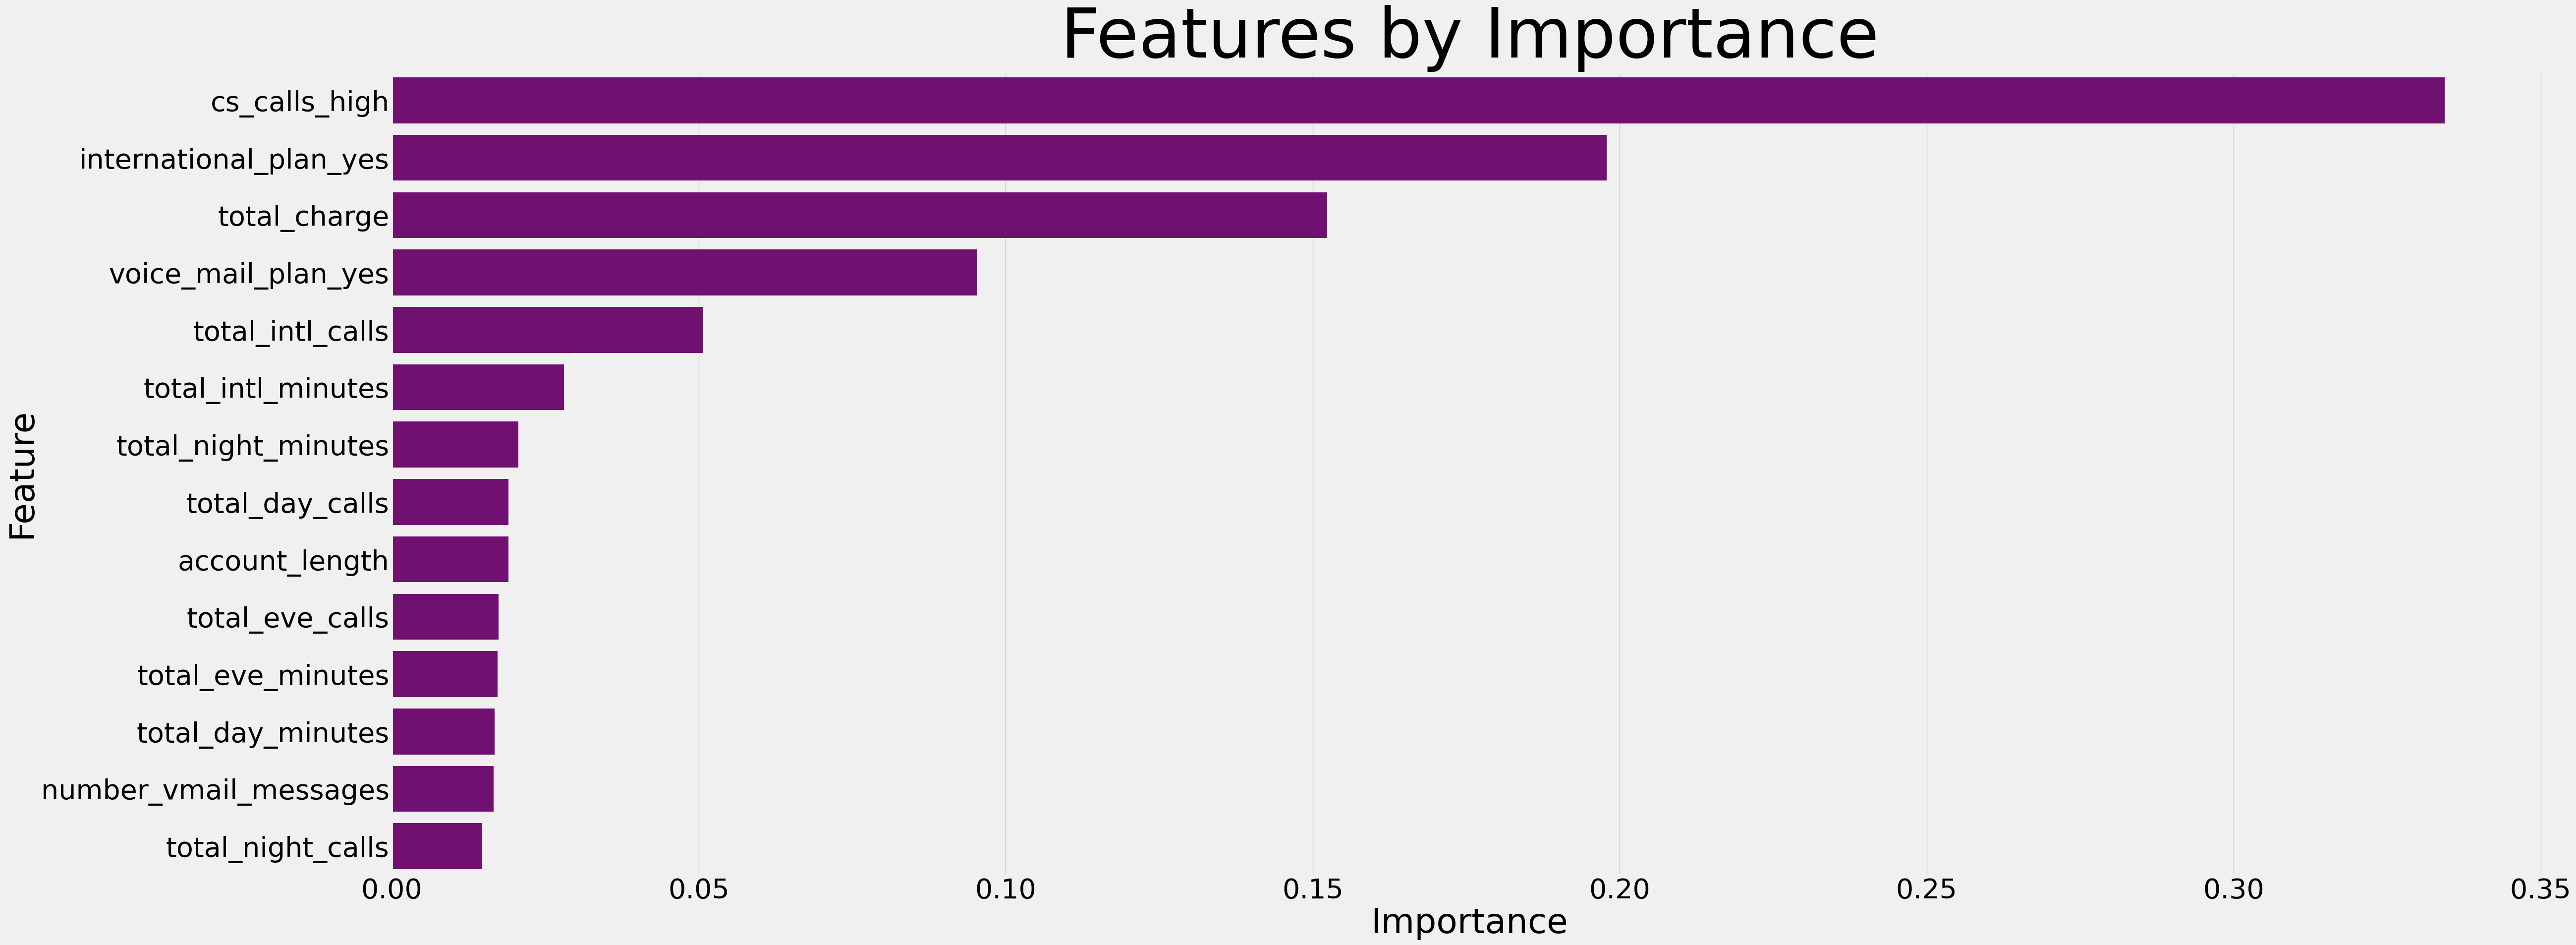

In [385]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color ='purple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 
plt.savefig('images/project_3_Feature_Importance')

plt.show();

## Analysis
The Top 4 features with importance in relation to churn are:
1. Excess Customer Service Calls
2. Customers with the International Plan.
3. Total Charge that Customer has.
4. Customers with a Voice Mail Plan.

All other features have (at most) half of the feature significance as the top 4. However, it is important to note that features 5 & 6 are both related to the International Plan.

I will take a closer look at each of these features as they have the most impact on churn by far.



All other features have (at most) half of the feature significance as the top 4. I will take a closer look at each of these features as they have the most impact on churn by far.

-----

# Churn Rate Analysis of the Most Relevant Features

## 1. Customer Service Calls

In [386]:
analysis_df = cleaned_df.copy()

In [387]:
df.customer_service_calls.describe()

count    3333.000000
mean        1.562856
std         1.315491
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: customer_service_calls, dtype: float64

In [388]:
# Assuming analysis_df is already defined and contains the necessary data

# Step 1: Group by 'customer_service_calls' and calculate the sum of 'churn'
cs_churn_df = analysis_df.groupby('customer_service_calls')['churn'].sum().reset_index()

# Step 2: Rename columns
cs_churn_df = cs_churn_df.rename(columns={'customer_service_calls': 'no_of_calls'})

# Step 3: Ensure 'no_of_calls' is of integer type
cs_churn_df['no_of_calls'] = cs_churn_df['no_of_calls'].astype(int)

# Step 4: Calculate the percentage of churn
cs_churn_df['percent'] = analysis_df.groupby('customer_service_calls')['churn'].mean().values

# Step 5: Reorder columns
cs_churn_df = cs_churn_df.reindex(columns=['no_of_calls', 'percent'])

# Step 6: Sort values by 'no_of_calls'
cs_churn_df = cs_churn_df.sort_values('no_of_calls')



# Display the dataframe
print(cs_churn_df)


   no_of_calls   percent
0            0  0.131994
1            1  0.103302
2            2  0.114625
3            3  0.102564
4            4  0.457831
5            5  0.606061
6            6  0.636364
7            7  0.555556
8            8  0.500000
9            9  1.000000


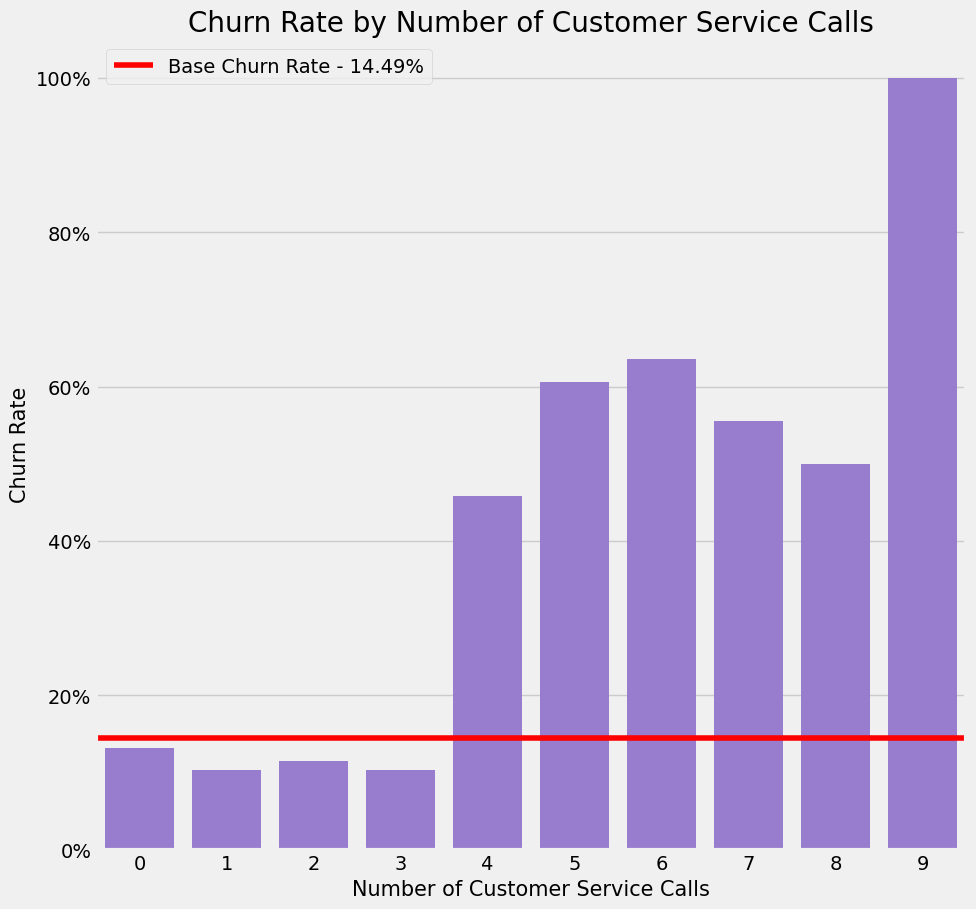

In [389]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.barplot(x="no_of_calls", y="percent", data=cs_churn_df, color='mediumpurple');

p.set_xlabel("Number of Customer Service Calls", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
p.set_title("Churn Rate by Number of Customer Service Calls", fontsize = 20)
plt.figsize=(30,20) 
line = plt.axhline(y=.145, color='red')
plt.savefig('images/project_3_CS_Churn_Rate')
ax.legend([line], ['Base Churn Rate - 14.49%'])

plt.show();

### Analysis:
- There is a very strong relationship between the number of Customer Service Calls and Churn Rate.
- If there are 0-3 calls, those customers are below the avg. churn rate.
- <b>At 4 Calls, the Churn Rate jumps to 45.7%, 4X the avg. churn rate.</b>
- The Mode for Customer Service Calls is 1, with 2 or more calls being in the top quartile.
- Over Half of all customers make 1 or less customer service calls. (1878 of 3333: 56%)
- Hypothesis is that customers that are unhappy (and therefore more likely to cancel their service) are calling customer service more often.

## 2. International Plan

In [390]:
intl_df = analysis_df[['international_plan_yes', 'international_plan_no', 'churn']]
intl_churn_df = intl_df.groupby('churn').sum().reset_index()
intl_churn_df = intl_churn_df.transpose()
intl_churn_df = intl_churn_df.rename(columns={0: "stayed", 1: "churned"})
intl_churn_df['total'] = intl_churn_df.apply(lambda x: x['stayed'] + x['churned'], axis=1)
intl_churn_df['churn_rate'] = intl_churn_df.apply(lambda x: x['churned'] / x['total'], axis=1)
intl_churn_df

,stayed,churned,total,churn_rate
churn,0.0,1.0,1.0,1.000000
international_plan_yes,186.0,137.0,323.0,0.424149
international_plan_no,2664.0,346.0,3010.0,0.114950


In [391]:
df2 = df.copy()
df2 = df2[['international_plan', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 
          'customer_service_calls', 'total_day_minutes', 'total_day_charge', 'churn']]

In [392]:
df2.groupby('international_plan').mean()

,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_day_minutes,total_day_charge,churn
international_plan,,,,,,,
no,10.195349,4.465449,2.753279,1.573422,178.893887,30.412495,0.114950
yes,10.628173,4.609907,2.869907,1.464396,187.986997,31.958390,0.424149


### Analysis:
<i>NOTE: Data shows that Customers without the international plan were still able to make international calls. I am operating under the assumption that the data is correct and that there is a seperate International Plan, as indicated bty the "International Plan" column. I am also assuming that the data contained in that field is accurate.</i>

- only 323 people (9.5% of customers) have international plans. But those that do have a high rate of churn.
- <b>churn rate for customers with an international plan is 42.4% vs 11.5% for those without an international plan.</b>
- nearly 4X increase in churn rate.
- customers without an international plan are actually under the avg. churn rate, but are close to it.
- International Minutes and the Number of International Calls were the 5th and 6th most important features. There is definitely something wrong with SyriaTel's International Plan. This will be reflected in my Recommendations.

## 3. Total Charge

In [393]:
analysis_df['total_charge'].describe()

count    3333.000000
mean       59.449754
std        10.502261
min        22.930000
25%        52.380000
50%        59.470000
75%        66.480000
max        96.150000
Name: total_charge, dtype: float64

In [397]:
charge_df = analysis_df[['total_charge', 'churn']]
charge_df['charge_group'] = pd.qcut(analysis_df['total_charge'], 200)

# Value counts & renaming with duplicate prevention
group_counts = (
    charge_df['charge_group']
    .value_counts()
    .rename_axis('charge_group')
    .reset_index(name='# of accounts')
)

# Merge while dropping potential duplicates
charge_df = charge_df.drop_duplicates(subset='charge_group').merge(group_counts, on='charge_group', how='left')

charge_df.head()


C:\Users\USER\AppData\Local\Temp\ipykernel_18564\2357017559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charge_df['charge_group'] = pd.qcut(analysis_df['total_charge'], 200)


,total_charge,churn,charge_group,# of accounts
0,75.56,0,"(75.267, 75.632]",17
1,59.24,0,"(59.097, 59.337]",17
2,62.29,0,"(62.199, 62.34]",18
3,66.80,0,"(66.633, 66.8]",18
4,52.09,0,"(51.93, 52.11]",17


ValueError: Could not interpret value `group_mean` for parameter `x`

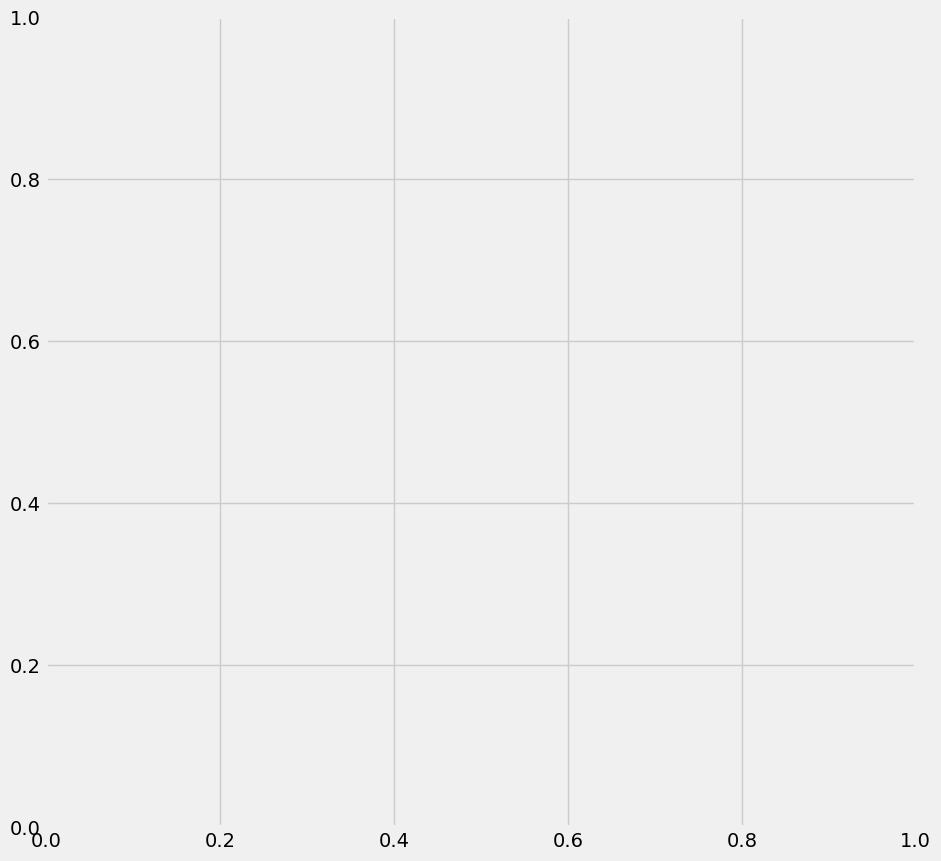

In [399]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10,10))
p = sns.scatterplot(x="group_mean", y="churn", data=charge_df);

p.set_xlabel("Total Charge: Mean Value", fontsize = 15)
p.set_ylabel("Churn Rate", fontsize = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
#p.xaxis.set_major_formatter(display_millions)
ax.xaxis.set_major_formatter('${x:1.2f}')

p.set_title("Churn Rate by Total Charge", fontsize = 20)
plt.figsize=(30,20) 

line_1 = plt.axhline(y=.145, color='firebrick')
line_2 = plt.axhline(y=0, color='black')
line_3 = plt.axvline(x=59.45, linestyle='--',color='mediumseagreen')
#line_4 = plt.axvline(x=74.00, color='skyblue')

ax.legend([line_1, line_3], ['Regular Churn Line', 'Mean Bill Charge'])
plt.savefig('images/project_3_total_charge_churn')


plt.show();

### Analysis
- Total Charge of $74 per month leads to Churn Rate of roughly 70% or greater!
- This affects aprox 240 customers (15 groups of 16)
- While there a a good amount of customers above the average churn line, if you add an extra 10%, almost all are within that range until you get to the extreme outliers.

## 4. Voice Mail Plan

In [ ]:
vm_df = analysis_df[['voice_mail_plan_yes', 'voice_mail_plan_no', 'churn']]
vm_df = vm_df.groupby('churn').sum().reset_index()
vm_df = vm_df.transpose()
vm_df = vm_df.rename(columns={0: "stayed", 1: "churned"})
vm_df['total'] = vm_df.apply(lambda x: x['stayed'] + x['churned'], axis=1)
vm_df['churn_rate'] = vm_df.apply(lambda x: x['churned'] / x['total'], axis=1)
vm_df[1:3]

,stayed,churned,total,churn_rate
voice_mail_plan_yes,842.0,80.0,922.0,0.086768
voice_mail_plan_no,2008.0,403.0,2411.0,0.167151


### Analysis:

- 323 people (27.6% of customers) have a voicemail plan.
- <b>Customers that do NOT have a voicemail plan have twice the churn rate of customers that do.</b>
- The churn rate for customers without voicemail is slightly higher than the base churn rate, but since the churn rate for customers with voicemail is significantly lower, that gives this good overall significance.


-----
-----

# Conclusions

## Questions to Answer: Revisited

### What is the Baseline Churn Rate?
- <b>14.49%</b>
- This is the percentage of churn that occured in the dataset I was provided.

### What Factors Contribute to Churn? Which has the biggest impact?

In [ ]:
feature_importance_df[0:4]

,Feature,Importance
13,cs_calls_high,0.373214
11,international_plan_yes,0.191074
10,total_charge,0.135295
12,voice_mail_plan_yes,0.108922


<b>The 4 factors that have the biggest impact on Churn (in order) are:</b>
1. Total Amount Charged
2. A High Number of Customer Service Calls.
3. Customer having an international plan.
4. Customer not having a voicemail plan.
- All other features have significantly less impact on Churn. (<.05 importance)

### What can be done to identify when a customer is at risk for churn?
Based on my analysis, here is where customers "cross the line" into being at a high risk for churn:
- Having a <b>Total Charge of $74</b> or more.
- Calling Customer Service <b>4 or more</b> times.
- Having an international plan.
- Not Having a Voice Mail plan.

-----
-----

# Recommendations

## Recommendation #1: Increased Focus on Customer Service.
- There is a sharp increase in Churn when a Customer reaches their 4th call to customer service. In order to retain more customers, <b>SyriaTel should focus on resolving whatever issues that customers bring up with Customer Service. If all questions are answered, and issues are explained and addressed, this should lead to happier customers, less customer service calls, and less churn.</b>
- Of course, the call itself isn't the issue. Customer service calls are a sign that something is wrong, and the more that a customer calls, the more likely they are to be having problems with the service and/or paying their bills.
- I recommend that SyriaTel analyze any data that they have on Customer Service calls to see what issues customers were bringing up and at what frequency. Proactively dealing with these issues will likely cause a decrease in churn.

-----

## Recommendation #2: Take a good look at your international plan and see why it increases the amount of Churn

- Customers without the international plan are able to make international calls.
- Customers with the international plan end up leaving. 
- I don't have data on how much the international plan costs or how it is used, but it is causing higher churn.
- Perhaps it costs too much, or doesn't give an advantage over not having the plan, or is inferior to the competition.
- International Minutes and Number of International Calls also have feature importance as well so they should also be investigated.

-----

## Recommendation #3: Offer a Flat Price Model to Combat High Customer Charges
- Making more money is good, but there is a strong correlation between churn and high charge. This indicates that customers are likely being charged per minute. SyriaTel would ultimately make MORE money by RETAINING the customers that they already have.
- By charging a flat fee, it eliminates any surprise that the customer has, which should result in less customer service calls, and less churn.
- The flat fee could be offered in tiers.
- The point of this recommendation is that customers know how much their bill is each month, even if they go over on minutes, etc.

-----

## Recommendation #4: Encourage Customers to get a Voice Mail Plan

- Also, analyze to see why there is such a big difference in churn rate when customers don't have a voice mail plan.

-----

## Recommendation #5: Set up a system which identifies when a customer is getting close to any of the thresholds identified above.

<i>Please Note: These recommenations are based on the way that everything is currently set up. If my other recommendations are followed, many of these issues would already be taken care of.</i>

### Green: Low Risk of Customer Churn.
- 0-1 Customer Service Calls.
- Customer Bill is $60/month or less.
- Customer does not have International Plan.
- Customer has Voice Mail Plan

### Yellow: Account is begining to show warning signs of churn. 
- 2-3 Customer Service Calls
- Customer Bill is above $60/month (the mean value)

### Red: Account is at high risk of churn.
- 4 or more Customer Service Calls
- Customer Monthly Bill is at $74 or higher.
- Customer has International Plan (in it's current form. See Recommendation #2)
- Customer does not have a Voice Mail Plan

-----
-----

# Summary